## The multispecies in space and time

Code to generate data and plots for Figure 3. The entire notebook takes about 1 hour to run on an 8 core laptop with 16Gb RAM. 

In [1]:
# conda create -n ipcoal python=3.7
# conda activate ipcoal
# conda install ipcoal -c conda-forge -c bioconda

In [2]:
import ipcoal
import toytree
import toyplot
import numpy as np
import pandas as pd
import scipy.stats
import time
import os

In [3]:
# parallel processing Py3
from concurrent.futures import ProcessPoolExecutor

In [4]:
# print versions of our libraries 
print('toytree', toytree.__version__)
print('ipcoal', ipcoal.__version__)

toytree 1.1.0
ipcoal 0.1.0


In [5]:
# make a subdirectory for storing some working files
WORKDIR = "results2"
os.makedirs(WORKDIR, exist_ok=True)

### Function to simulate genealogies
This will be used to explore the effect of Ne, r, height, ntips on genealogical patterns distributed spatially across a genome. 

In [6]:
def sim_locus_fixed_t(ntips, height, coal, nloci, nsites, seed=123):
    """
    Return an ipcoal.Model object with genealogies simulated
    for 'nloci' and 'nsites' on an imbalanced 'tree' with Ne auto
    scaled so that all internal edges are 'coal' units long. 
    """
    # generate imbalanced tree
    tree = toytree.rtree.imbtree(ntips=ntips)
    tree = tree.mod.node_scale_root_height(height, include_stem=True)
    
    # get internode dist
    dist = tree.treenode.dist
    
    # get Ne by scaling coalunits by internode height
    Ne = dist / (coal * 2.)
    
    # init model and sim n unlinked genealogies
    model = ipcoal.Model(tree, Ne=Ne, seed=seed)
    model.sim_loci(nloci=nloci, nsites=nsites)
    return model

#### Simulate genealogies and genetic data (JC model)

The decay rate for this model is -3.055016485482079e-05.

In [7]:
# height=1e6, ntips=100, coal=1.0
decay_rate = -3.055016485482079e-05     # 100 tips
# height=1e6, ntips=50, coal=1.0
decay_rate = -5.832539108467967e-05     # 50 tips
# height=1e6, ntips=50, coal=0.2
decay_rate = -0.00037695927164104625

In [8]:
model = sim_locus_fixed_t(
    ntips=50, 
    height=1e6, 
    coal=0.2, 
    nloci=1, 
    nsites=1e6, 
    seed=123,
)

In [9]:
# save results so notebook can be restarted from here
model.df.to_csv(os.path.join(WORKDIR, "loc1M-50tips-0.2c.csv"))
model.seqs.tofile(os.path.join(WORKDIR, "loc1M-50tips-0.2c.npy"))

### Function to compare gene trees and genealogies

In [10]:
def get_RF_gtge(gt, ge):
    """
    Input is two dataframes, the first empirical with 
    .inferred_trees and the second simulated with 
    .genealogies. It returns a dataframe with RF distances
    between the trees at every position of the genome. 
    """
    
    # combine the indices
    pos = sorted(set(gt.start.tolist() + ge.start.tolist()))
    end = pos[1:] + [max(set(gt.end.tolist() + ge.end.tolist()))]

    # organize for output
    data = pd.DataFrame({
        "start": pos,
        "end": end,
        "length": [i - j for (i, j) in zip(end, pos)],
        "rf": 0,
        "rfsum": 0,
    })

    # get rf dists 
    for idx in data.index:
        
        # get rows
        mt = gt.loc[gt.end > data.start[idx]]
        me = ge.loc[ge.end > data.start[idx]]
        
        # get indices
        nt = gt.loc[mt.index.min(), "inferred_tree"]
        ne = ge.loc[me.index.min(), "genealogy"]
        
        # get treenodes
        tt = toytree.tree(nt).treenode
        te = toytree.tree(ne).treenode
        
        # get rf dist
        rf = tt.robinson_foulds(te, unrooted_trees=True)
        data.loc[idx, "rf"] = rf[0]
        data.loc[idx, "rfsum"] = rf[0] * data.loc[idx, "length"]
    
    return data

### Function to plot RF dists

In [11]:
def plot_rf_empirical_inferred(sliding, maxpos=None):
    """
    Draws RF dist along the chromosome from an input
    dictionary of dataframes {name: dataframe}.
    Dataframes have start and rf as columns.
    """   
    # get drawing setup
    canvas = toyplot.Canvas(width=600, height=250)
    axes = canvas.cartesian()
    
    # add markers
    for key, rfdf in sliding.items():
        
        # get index of (optional) maxpos
        if maxpos:
            idx = rfdf.loc[rfdf.start < maxpos].index.max()
            rfdf = rfdf.iloc[:idx]
        
        # plot it
        axes.plot(
            rfdf.start[:maxpos], 
            rfdf.rf[:maxpos],
            stroke_width=1.5,
            opacity=0.75,
        )
    
    # add styling
    axes.x.ticks.show = True
    axes.y.ticks.show = True
    return canvas, axes

### Infer empirical gene trees in windows

In [12]:
# window_sizes = [1000, 2500, 10000, 25000, 250000, 1000000]

# # store standard sliding window results
# sliding = {}
# for wsize in window_sizes:
    
#     # get estimated gene trees
#     edata = model.infer_gene_tree_windows(wsize, 'raxml', {'T': '8'})
    
#     # get RF between estimated and true
#     sliding[wsize] = get_RF_gtge(edata, model.df)
    
#     # save to CSV
#     sliding[wsize].to_csv(os.path.join(WORKDIR, "window-RF-{}.csv".format(wsize)))

Reload sliding dictionary from datafiles in case we restart the notebook from this point. 

In [13]:
# import glob

# # get csv files
# keys = glob.glob(os.path.join(WORKDIR, "window-RF-*.csv"))

# # reload dictionary
# sliding = {}
# for key in sorted(keys):
    
#     # get window size
#     wsize = int(key.split("-w")[-1].split(".csv")[0])
    
#     # load dataframe
#     df = pd.read_csv(key, index_col=0)
#     sliding[wsize] = df
    
#     # print summed RFs integrated over all sites
#     print(key, "\t", sliding[wsize].rfsum.sum())

#### Plot RF across genome

In [45]:
plot_rf_empirical_inferred(sliding, 1000000);

<svg class="toyplot-canvas-Canvas" height="250.0px" id="ta1babb42cffa4aedbc196c84f998330c" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 600.0 250.0" width="600.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> <path d="M 50.0 70.0 L 50.052499999999995 73.33333333333333 L 50.225500000000004 70.0 L 50.322 70.0 L 50.344500000000004 70.0 L 50.5 90.0 L 50.791000000000004 90.0 L 50.88099999999999 93.33333333333333 L 51.0 76.66666666666667 L 51.0465 76.66666666666667 L 51.259499999999996 76.66666666666667 L 51.5 63.33333333333334 L 51.6125 63.33333333333334 L 52.0 76.66666666666667 L 52.0345 76.66666666666667 L 52.312999999999995 76.66666666666667 L 52.451 76.66666666666667 L 52.5 80.0 L 52.733999999999995 80.0 L 52.959500000000006 80.0 L 53.0 76.66666666666667 L 53.111000000000004 80.0 L 53.4225 80.0 L 53.5 100.0 L 53.659 100.0 L 53.675 100.0 L 54.0 100.0 L 54.5 76.66666666666667 L 54.6235 76.66666666666667 L 55.0 70.0 L 55.1885 70.0 L 55.5 103.33333333333331 L 55.766999999999996 103.33333333333331 L 56.0 96.66666666666666 L 56.1365 96.66666666666666 L 56.254999999999995 96.66666666666666 L 56.346999999999994 93.33333333333333 L 56.46549999999999 93.33333333333333 L 56.5 100.0 L 56.6915 100.0 L 56.7555 100.0 L 57.0 80.0 L 57.1735 80.0 L 57.177 80.0 L 57.5 66.66666666666667 L 57.528499999999994 66.66666666666667 L 57.8875 66.66666666666667 L 57.924 63.33333333333334 L 58.0 70.0 L 58.009 70.0 L 58.4395 70.0 L 58.5 93.33333333333333 L 58.726 103.33333333333331 L 59.0 76.66666666666667 L 59.3485 76.66666666666667 L 59.5 100.0 L 59.532000000000004 100.0 L 59.559 100.0 L 59.78450000000001 103.33333333333331 L 59.947500000000005 103.33333333333331 L 60.0 103.33333333333331 L 60.164500000000004 103.33333333333331 L 60.361000000000004 103.33333333333331 L 60.5 76.66666666666667 L 60.7655 76.66666666666667 L 61.0 86.66666666666667 L 61.084 86.66666666666667 L 61.440000000000005 86.66666666666667 L 61.5 63.33333333333334 L 61.5065 63.33333333333334 L 61.771 63.33333333333334 L 61.8085 70.0 L 61.8495 73.33333333333333 L 61.970000000000006 73.33333333333333 L 62.0 66.66666666666667 L 62.421 66.66666666666667 L 62.5 83.33333333333334 L 62.905 83.33333333333334 L 62.99999999999999 90.0 L 63.16 90.0 L 63.2025 93.33333333333333 L 63.22 90.0 L 63.2915 90.0 L 63.5 73.33333333333333 L 63.673 73.33333333333333 L 63.703 73.33333333333333 L 63.8125 73.33333333333333 L 63.988 73.33333333333333 L 64.0 73.33333333333333 L 64.057 76.66666666666667 L 64.2555 76.66666666666667 L 64.5 59.99999999999999 L 64.614 59.99999999999999 L 64.864 59.99999999999999 L 65.0 116.66666666666666 L 65.3465 116.66666666666666 L 65.5 80.0 L 65.674 83.33333333333334 L 66.0 70.0 L 66.211 70.0 L 66.26400000000001 70.0 L 66.40050000000001 70.0 L 66.5 70.0 L 66.803 70.0 L 67.0 59.99999999999999 L 67.057 59.99999999999999 L 67.5 83.33333333333334 L 67.59649999999999 83.33333333333334 L 68.0 66.66666666666667 L 68.01350000000001 66.66666666666667 L 68.2535 66.66666666666667 L 68.3675 66.66666666666667 L 68.5 73.33333333333333 L 68.575 73.33333333333333 L 69.0 76.66666666666667 L 69.1495 76.66666666666667 L 69.5 96.66666666666666 L 69.615 100.0 L 69.80799999999999 96.66666666666666 L 70.0 86.66666666666667 L 70.064 86.66666666666667 L 70.15700000000001 86.66666666666667 L 70.2475 86.66666666666667 L 70.443 86.66666666666667 L 70.5 76.66666666666667 L 70.9105 76.66666666666667 L 71.0 83.33333333333334 L 71.5 96.66666666666666 L 71.8485 96.66666666666666 L 72.0 70.0 L 72.4755 70.0 L 72.5 76.66666666666667 L 72.978 76.66666666666667 L 73.0 73.33333333333333 L 73.0015 73.33333333333333 L 73.09450000000001 73.33333333333333 L 73.128 73.33333333333333 L 73.259999

### Infer empirical gene trees in *weighted* sliding windows

Here we will apply an exponential weighting to sites that decays away from the center of the sliding window. The decay function can be any rate, but we show that the rate estimated from the species tree model performs the best. 

In [14]:
def get_exponential_weight_window(seq, midpoint, decay, maxweight=100):
    """
    For an alignment create a weight file covering the full
    length and which decays exponentially from the midpoint
    according to an exponential decay lambda parameter. The
    weights file will be scaled to integers and used in raxml.
    The min weight is set to 1 and the max weight is set to 
    whatever multiplier is needed to scale weights. The max
    weight argument determines the endpoints to trim the seq
    and the seq is returned with only regions that have weight.
    Example:
               mid
    ------------^---------------------------
               / \
    __________/   \_________________________
    0011111111489841111111100000000000000000
    
    Returns:
    seq:  ---------------------
    start: 0
    end: 500000
    wgts: 11111114898411111111
    """
    # do not modify original seq
    seq = seq.copy()
    
    # decay function
    exp = scipy.stats.expon(loc=midpoint, scale=abs(1 / decay))
    
    # the minimum weight is one everywhere
    wgts = np.ones(seq.shape[1], dtype=int)
    probs = np.zeros(seq.shape[1], dtype=float)
    
    # get probability at this site (midpoint)
    maxprob = exp.pdf(midpoint)
       
    # find farthest point to left or right
    toend = max(midpoint, seq.shape[1] - midpoint)

    # project probs to the furthest dist
    iprob = np.array(
        [exp.pdf(i) for i in range(midpoint, midpoint + toend)]
    )

    # project probs to the right
    probs[midpoint:] = iprob[:seq.shape[1] - midpoint]

    # project probs to the left
    probs[:midpoint] = iprob[:midpoint][::-1]

    # trim seq to end points
    scaled = np.where(probs > maxprob / maxweight)[0]
    start = scaled.min() 
    end = scaled.max()
    seq = seq[:, start:end]
    
    # scale weights from 1-maxweight
    wgts = wgts[start:end]
    wgts = wgts * (probs[start:end] / probs[start:end].min())
    return start, end, seq, wgts.astype(int)

### Function to get weighted tree at a position

In [15]:
def infer_weighted_tree(model, pos, decay, maxweight):
    """
    Describe...
    """
    # get chromosome from model object
    seq = model.seqs[0]
    
    # get seq window by applying decay func to seq position
    res = get_exponential_weight_window(seq, pos, decay, maxweight)
    start, end, seq, wgts = res
    
    # weight file named by pid to allow multiprocessing
    wgtfile = "/tmp/weightfile.{}".format(os.getpid())
    with open(wgtfile, 'w') as out:
        out.write(" ".join([str(i) for i in wgts]))
        
    # init raxml inference object with weightfile
    ti = ipcoal.TreeInfer.TreeInfer(
        seqs=np.array([seq]),
        names=model.alpha_ordered_names,
        inference_method="raxml",
        inference_args={
            "T": "8",
            "a": wgtfile,
            "N": "1",
        }
    )
    
    # run raxml 
    newick = ti.run(0)
    return newick

# Routine
Sample 1000 places in the genome and at each one infer a window of:
    
    1. Uniform window = 1000, 2500, 10000, 25000, 250000, 1000000
    2. Weighted window = decay_estimate / 10, decay_estimate, decay_estimate * 10
    
```
decay_rate    window_size     sum-RF    mean-RF
     --           1000        1000       100.3
     --           5000         500        25.3
  -3.0e-5         4333         250        10.3
  -3.0e-6          333         100        5.3
  ...
```

In [16]:
import copy

In [ ]:
# window sizes are half b/c they stretch from pos in both directions
positions = np.linspace(50000, 950000, 25).astype(int)
window_sizes = [1250, 5000, 12500, 50000][::-1]
rates = [decay_rate * 10, decay_rate * 2, decay_rate]

### TODO: wrap it all in a function

In [ ]:
def full_wrap(ntips, height, coal, ):
    
    # simulate the chromosome
    model = sim_locus_fixed_t(
        ntips=ntips, 
        height=height, 
        coal=coal,
        nloci=1, 
        nsites=1e6,
        seed=123,
    )
    
    # infer the decay rate and load decay dict
    
    
    # store results
    res_stats = pd.DataFrame({
        "position": [0] * len(positions) * 8,
        "window": [0] * len(positions) * 8,
        "decay": [0.] * len(positions) * 8,
        "RF": [0.] * len(positions) * 8,
    })
    
    # get concatenation tree
    ti = ipcoal.TreeInfer.TreeInfer(
        seqs=model.seqs[0],
        names=model.alpha_ordered_names,
        inference_method="raxml",
        inference_args={
            "T": "8",
            "N": "1",
            }
        )
    concat_newick = ti.run(0)
    
    # iterate over jobs
    
    
# iterate over positions
idx = 0
for pos in positions:
    
    # get the true tree
    gtree = model.df.loc[model.df[model.df.start <= pos].index.max()].genealogy
    gtree = toytree.tree(gtree)
    
    # get RF of local and concat tree
    rf = (
        toytree.tree(concat_newick).treenode.robinson_foulds(
        gtree.treenode, unrooted_trees=True)[0]
    )

    # store the gene tree and RF
    res_trees["{}-{}".format(pos, int(1e6))] = concat_newick
    res_stats.iloc[idx] = (pos, 1e6, 0, rf)
    print('window', pos, int(1e6), rf)
    idx += 1
    
    # iterate over window sizes:
    for wz in window_sizes:

        # get a tmp copy of the model object
        _model = copy.deepcopy(model)
        
        # subset the sequence array to window
        left = max(0, pos - wz)
        right = min(pos + wz, int(model.seqs.shape[2]))
        _model.seqs = np.array([model.seqs[0, :, left:right]].copy())
        
        # infer raxml tree in uniform window
        _model.infer_gene_trees(inference_args={"T": "8", "N": "1"})
        
        # calculate rf dist
        newick = _model.df.iloc[0, -1]
        rf = (toytree.tree(newick).treenode.robinson_foulds(
            gtree.treenode, unrooted_trees=True)[0])
        
        # store the gene tree
        res_trees["{}-{}".format(pos, wz)] = newick
        res_stats.iloc[idx] = (pos, wz, 0, rf)
        print('window', pos, wz * 2, rf)
        idx += 1
        
    # infer weighted tree at this position
    for idx, decay in enumerate(rates):

        # get chromosome from model object
        _model = copy.deepcopy(model)
        seq = _model.seqs[0]

        # get seq window by applying decay func to seq position
        res = get_exponential_weight_window(seq, pos, decay, 1000)
        start, end, seq, wgts = res

        # weight file named by pid to allow multiprocessing
        wgtfile = "/tmp/weightfile.{}".format(os.getpid())
        with open(wgtfile, 'w') as out:
            out.write(" ".join([str(i) for i in wgts]))

        # init raxml inference object with weightfile
        ti = ipcoal.TreeInfer.TreeInfer(
            seqs=np.array([seq]),
            names=model.alpha_ordered_names,
            inference_method="raxml",
            inference_args={
                "T": "8",
                "a": wgtfile,
                "N": "1",
            }
        )
        newick = ti.run(0)
        rf = (toytree.tree(newick).treenode.robinson_foulds(
            gtree.treenode, unrooted_trees=True)[0])
                               
        # store the gene tree
        res_trees["{}-decay{}".format(pos, idx)] = newick
        res_stats.iloc[idx] = (pos, seq.shape[1], idx, rf)
        idx += 1
        print('weight', pos, idx, seq.shape[1], rf)
    
    # save table periodically
    res_stats.to_csv(os.path.join(WORKDIR, "sliding-table.csv"))

array([ 50000.,  87500., 125000., 162500., 200000., 237500., 275000.,
       312500., 350000., 387500., 425000., 462500., 500000., 537500.,
       575000., 612500., 650000., 687500., 725000., 762500., 800000.,
       837500., 875000., 912500., 950000.])

In [223]:
seq = model.seqs[0].copy()

In [224]:
dec = -0.00037695927164104625
x = get_exponential_weight_window(seq, 500000, dec, 1000)

In [226]:
dec = -0.00037695927164104625
y = get_exponential_weight_window(seq, 500000, dec * 10, 1000)

In [227]:
x[2].shape, y[2].shape

((50, 36649), (50, 3665))

In [163]:
# window sizes are half b/c they stretch from pos in both directions
np.random.seed(333)
positions = np.linspace(50000, 950000, 25).astype(int)
#window_sizes = [1250, 5000, 12500, 50000][::-1]
window_sizes = [500]
#rates = [decay_rate * 10, decay_rate * 2, decay_rate]
rates = [decay_rate * 5]

# store results
res_stats = pd.DataFrame({
    "position": [0] * len(positions) * 8,
    "window": [0] * len(positions) * 8,
    "decay": [0.] * len(positions) * 8,
    "RF": [0.] * len(positions) * 8,
})
res_trees = {}

# full concatenation
# _model = copy.deepcopy(model)
# _model.infer_gene_trees(inference_args={"T": "8", "N": "1"})
# concat_newick = _model.df.iloc[0, -1]

# iterate over positions
idx = 0
for pos in positions:
    
    # get the true tree
    gtree = model.df.loc[model.df[model.df.start <= pos].index.max()].genealogy
    gtree = toytree.tree(gtree)
    
    # get RF of local and concat tree
    rf = (
        toytree.tree(concat_newick).treenode.robinson_foulds(
        gtree.treenode, unrooted_trees=True)[0]
    )

    # store the gene tree and RF
#     res_trees["{}-{}".format(pos, int(1e6))] = concat_newick
#     res_stats.iloc[idx] = (pos, 1e6, 0, rf)
#     print('window', pos, int(1e6), rf)
#     idx += 1
    
    # iterate over window sizes:
    for wz in window_sizes:

        # get a tmp copy of the model object
        _model = copy.deepcopy(model)
        
        # subset the sequence array to window
        left = max(0, pos - wz)
        right = min(pos + wz, int(model.seqs.shape[2]))
        _model.seqs = np.array([model.seqs[0, :, left:right]].copy())
        
        # infer raxml tree in uniform window
        _model.infer_gene_trees(inference_args={"T": "8", "N": "1"})
        
        # calculate rf dist
        newick = _model.df.iloc[0, -1]
        rf = (toytree.tree(newick).treenode.robinson_foulds(
            gtree.treenode, unrooted_trees=True)[0])
        
        # store the gene tree
        res_trees["{}-{}".format(pos, wz)] = newick
        res_stats.iloc[idx] = (pos, wz, 0, rf)
        print('window', pos, wz * 2, rf)
        idx += 1
        
    # infer weighted tree at this position
    for idx, decay in enumerate(rates):

        # get chromosome from model object
        _model = copy.deepcopy(model)
        seq = _model.seqs[0]

        # get seq window by applying decay func to seq position
        res = get_exponential_weight_window(seq, pos, decay, 1000)
        start, end, seq, wgts = res

        # weight file named by pid to allow multiprocessing
        wgtfile = "/tmp/weightfile.{}".format(os.getpid())
        with open(wgtfile, 'w') as out:
            out.write(" ".join([str(i) for i in wgts]))

        # init raxml inference object with weightfile
        ti = ipcoal.TreeInfer.TreeInfer(
            seqs=np.array([seq]),
            names=model.alpha_ordered_names,
            inference_method="raxml",
            inference_args={
                "T": "8",
                "a": wgtfile,
                "N": "1",
            }
        )
        newick = ti.run(0)
        rf = (toytree.tree(newick).treenode.robinson_foulds(
            gtree.treenode, unrooted_trees=True)[0])
                               
        # store the gene tree
        res_trees["{}-decay{}".format(pos, idx)] = newick
        res_stats.iloc[idx] = (pos, seq.shape[1], idx, rf)
        idx += 1
        print('weight', pos, idx, seq.shape[1], rf)
    
    # save table periodically
    #res_stats.to_csv(os.path.join(WORKDIR, "sliding-table.csv"))

window 50000 1000 62
weight 50000 1 7329 32
window 87500 1000 76
weight 87500 1 7329 46
window 125000 1000 56
weight 125000 1 7329 22
window 162500 1000 64
weight 162500 1 7329 38
window 200000 1000 60
weight 200000 1 7329 28
window 237500 1000 60
weight 237500 1 7329 34
window 275000 1000 70
weight 275000 1 7329 40
window 312500 1000 60
weight 312500 1 7329 28
window 350000 1000 54
weight 350000 1 7329 30
window 387500 1000 68
weight 387500 1 7329 42
window 425000 1000 50
weight 425000 1 7329 42
window 462500 1000 72
weight 462500 1 7329 40
window 500000 1000 54
weight 500000 1 7329 34
window 537500 1000 56
weight 537500 1 7329 28
window 575000 1000 66
weight 575000 1 7329 28
window 612500 1000 66
weight 612500 1 7329 38
window 650000 1000 66
weight 650000 1 7329 34
window 687500 1000 60
weight 687500 1 7329 30
window 725000 1000 52
weight 725000 1 7329 38
window 762500 1000 60
weight 762500 1 7329 22
window 800000 1000 66
weight 800000 1 7329 42
window 837500 1000 72
weight 837500 1 

In [165]:
lost2 = """
window 50000 1000 62
weight 50000 7329 32
window 87500 1000 76
weight 87500 7329 46
window 125000 1000 56
weight 125000 7329 22
window 162500 1000 64
weight 162500 7329 38
window 200000 1000 60
weight 200000 7329 28
window 237500 1000 60
weight 237500 7329 34
window 275000 1000 70
weight 275000 7329 40
window 312500 1000 60
weight 312500 7329 28
window 350000 1000 54
weight 350000 7329 30
window 387500 1000 68
weight 387500 7329 42
window 425000 1000 50
weight 425000 7329 42
window 462500 1000 72
weight 462500 7329 40
window 500000 1000 54
weight 500000 7329 34
window 537500 1000 56
weight 537500 7329 28
window 575000 1000 66
weight 575000 7329 28
window 612500 1000 66
weight 612500 7329 38
window 650000 1000 66
weight 650000 7329 34
window 687500 1000 60
weight 687500 7329 30
window 725000 1000 52
weight 725000 7329 38
window 762500 1000 60
weight 762500 7329 22
window 800000 1000 66
weight 800000 7329 42
window 837500 1000 72
weight 837500 7329 36
window 875000 1000 50
weight 875000 7329 26
window 912500 1000 60
weight 912500 7329 30
window 950000 1000 52
weight 950000 7329 32
"""

In [71]:
lost = """
window 50000 1000000 88
window 50000 100000 86
window 50000 25000 70
window 50000 10000 52
window 50000 2500 48
weight 50000 3665 44
weight 50000 18325 38
weight 50000 36649 56
window 87500 1000000 88
window 87500 100000 90
window 87500 25000 76
window 87500 10000 52
window 87500 2500 66
weight 87500 3665 50
weight 87500 18325 46
weight 87500 36649 52
window 125000 1000000 66
window 125000 100000 78
window 125000 25000 56
window 125000 10000 42
window 125000 2500 34
weight 125000 3665 26
weight 125000 18325 24
weight 125000 36649 26
window 162500 1000000 84
window 162500 100000 76
window 162500 25000 58
window 162500 10000 50
window 162500 2500 36
weight 162500 3665 40
weight 162500 18325 34
weight 162500 36649 52
window 200000 1000000 86
window 200000 100000 72
window 200000 25000 62
window 200000 10000 32
window 200000 2500 40
weight 200000 3665 44
weight 200000 18325 26
weight 200000 36649 28
window 237500 1000000 82
window 237500 100000 78
window 237500 25000 56
window 237500 10000 58
window 237500 2500 46
weight 237500 3665 38
weight 237500 18325 40
weight 237500 36649 46
window 275000 1000000 78
window 275000 100000 76
window 275000 25000 66
window 275000 10000 50
window 275000 2500 36
weight 275000 3665 32
weight 275000 18325 34
weight 275000 36649 40
window 312500 1000000 80
window 312500 100000 82
window 312500 25000 44
window 312500 10000 42
window 312500 2500 42
weight 312500 3665 38
weight 312500 18325 26
weight 312500 36649 26
window 350000 1000000 78
window 350000 100000 68
window 350000 25000 78
window 350000 10000 60
window 350000 2500 48
weight 350000 3665 38
weight 350000 18325 50
weight 350000 36649 40
window 387500 1000000 78
window 387500 100000 68
window 387500 25000 58
window 387500 10000 54
window 387500 2500 48
weight 387500 3665 58
weight 387500 18325 48
weight 387500 36649 44
window 425000 1000000 82
window 425000 100000 76
window 425000 25000 70
window 425000 10000 60
window 425000 2500 50
weight 425000 3665 40
weight 425000 18325 44
weight 425000 36649 44
window 462500 1000000 88
window 462500 100000 70
window 462500 25000 70
window 462500 10000 62
window 462500 2500 56
weight 462500 3665 52
weight 462500 18325 42
weight 462500 36649 36
window 500000 1000000 80
window 500000 100000 74
window 500000 25000 74
window 500000 10000 36
window 500000 2500 34
weight 500000 3665 48
weight 500000 18325 24
weight 500000 36649 30
window 537500 1000000 84
window 537500 100000 76
window 537500 25000 56
window 537500 10000 50
window 537500 2500 38
weight 537500 3665 50
weight 537500 18325 30
weight 537500 36649 34
window 575000 1000000 68
window 575000 100000 62
window 575000 25000 52
window 575000 10000 40
window 575000 2500 38
weight 575000 3665 32
weight 575000 18325 24
weight 575000 36649 26
window 612500 1000000 72
window 612500 100000 70
window 612500 25000 64
window 612500 10000 48
window 612500 2500 62
weight 612500 3665 40
weight 612500 18325 44
weight 612500 36649 46
window 650000 1000000 70
window 650000 100000 74
window 650000 25000 52
window 650000 10000 42
window 650000 2500 46
weight 650000 3665 36
weight 650000 18325 22
weight 650000 36649 28
window 687500 1000000 84
window 687500 100000 82
window 687500 25000 62
window 687500 10000 48
window 687500 2500 58
weight 687500 3665 50
weight 687500 18325 20
weight 687500 36649 40
window 725000 1000000 82
window 725000 100000 68
window 725000 25000 70
window 725000 10000 60
window 725000 2500 58
weight 725000 3665 40
weight 725000 18325 32
weight 725000 36649 62
window 762500 1000000 78
window 762500 100000 72
window 762500 25000 60
window 762500 10000 40
window 762500 2500 36
weight 762500 3665 40
weight 762500 18325 28
weight 762500 36649 34
window 800000 1000000 78
window 800000 100000 68
window 800000 25000 60
window 800000 10000 56
window 800000 2500 44
weight 800000 3665 44
weight 800000 18325 34
weight 800000 36649 40
window 837500 1000000 76
window 837500 100000 74
window 837500 25000 58
window 837500 10000 48
window 837500 2500 52
weight 837500 3665 44
weight 837500 18325 32
weight 837500 36649 36
window 875000 1000000 88
window 875000 100000 80
window 875000 25000 62
window 875000 10000 58
window 875000 2500 40
weight 875000 3665 28
weight 875000 18325 34
weight 875000 36649 54
window 912500 1000000 86
window 912500 100000 74
window 912500 25000 64
window 912500 10000 48
window 912500 2500 44
weight 912500 3665 36
weight 912500 18325 28
weight 912500 36649 42
window 950000 1000000 92
window 950000 100000 88
window 950000 25000 78
window 950000 10000 72
window 950000 2500 46
weight 950000 3665 30
weight 950000 18325 26
weight 950000 36649 24
"""

In [166]:
import io
ilost = io.StringIO(lost.strip())
arr = pd.read_csv(ilost, delim_whitespace=True, names=["type", "pos", "window", "RF"])

In [167]:
ilost = io.StringIO(lost2.strip())
arr2 = pd.read_csv(ilost, delim_whitespace=True, names=["type", "pos", "window", "RF"])

In [171]:
aarr = pd.concat([arr, arr2])


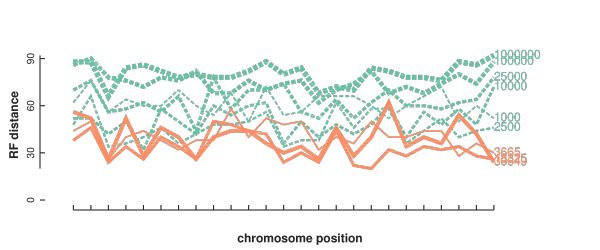

In [183]:
canvas = toyplot.Canvas(width=600, height=250);
axes = canvas.cartesian()

width_dict = {
    1000000: 5,
    100000: 4,
    25000: 3,
    10000: 2.5,
    2500: 2,
    1000: 1.5,
}

for window in [1000000, 100000, 25000, 10000, 2500, 1000]:

    axes.plot(
        aarr[aarr.window==window].pos,
        aarr[aarr.window==window].RF,
        style={"stroke-dasharray": "4, 2"},
        stroke_width = width_dict[window],
        color=toyplot.color.Palette()[0]
    )
    axes.text(
        aarr[aarr.window==window].pos.values[-1],
        aarr[aarr.window==window].RF.values[-1],
        "{}".format(window),  # aarr[aarr.window==window].RF.sum()),
        style={"text-anchor": "start"},
        color=toyplot.color.Palette()[0]
    )

width_dict = {
    3665: 1.5, 
    18325: 2.75,
    36649: 3.5,
}
for decay in [3665, 18325, 36649]:
    axes.plot(
        aarr[aarr.window==decay].pos,
        aarr[aarr.window==decay].RF,
        stroke_width=width_dict[decay],
        color=toyplot.color.Palette()[1]
    )
    axes.text(
        aarr[aarr.window==decay].pos.iloc[-1],
        aarr[aarr.window==decay].RF.iloc[-1],
        "{}".format(decay),
        style={"text-anchor": "start"},
        color=toyplot.color.Palette()[1]
    )
axes.y.domain.min = 0.
axes.x.domain.min = 0
axes.x.domain.max = 1.07e6
axes.x.ticks.locator = toyplot.locator.Explicit(
    np.linspace(50000, 950000, 25).astype(int),
    ["" for i in np.linspace(50000, 950000, 25)],
)
axes.x.ticks.show = True
axes.x.label.text = "chromosome position"
axes.y.label.text = "RF distance"
axes.y.ticks.show = True

import toyplot.svg
toyplot.svg.render(canvas, "../manuscript/figures/Fig-3-pre.svg")
canvas

In [185]:
for i in aarr.window.unique():
    print(i, aarr[aarr.window==i].RF.sum(), aarr[aarr.window==i].RF.mean())

1000000 2016 80.64
100000 1882 75.28
25000 1576 63.04
10000 1260 50.4
2500 1146 45.84
3665 1018 40.72
18325 830 33.2
36649 986 39.44
1000 1532 61.28
7329 840 33.6


In [36]:
model.seqs.shape

(1, 50, 1000000)

In [38]:
_model.seqs.shape

(1, 50, 0)

In [34]:
#_model = copy.deepcopy(model)
_model.seqs.shape

(1, 50, 1000000)

In [32]:
get_exponential_weight_window(_model.seqs[0], pos, decay_rate, 1000)

(6675, 43324, array([[0, 3, 3, ..., 0, 0, 0],
        [0, 3, 3, ..., 0, 0, 0],
        [0, 3, 3, ..., 0, 0, 0],
        ...,
        [0, 3, 3, ..., 0, 0, 0],
        [0, 3, 3, ..., 0, 0, 0],
        [0, 3, 3, ..., 0, 0, 0]], dtype=uint8), array([1, 1, 1, ..., 1, 1, 1]))

In [ ]:

window 335852 1000000.0 38
window 335852 10000 56
window 335852 25000 56
window 335852 100000 48
window 335852 250000 44
weight 335852 1 118435 54
weight 335852 2 236869 50
weight 335852 3 473739 48
window 685836 1000000.0 38
window 685836 10000 38
window 685836 25000 36
window 685836 100000 34
window 685836 250000 36
weight 685836 1 118435 34
weight 685836 2 236869 34
weight 685836 3 473739 34


In [100]:
window 486191 10000 126
window 486191 25000 112
window 486191 100000 106
window 486191 250000 84
weight 486191 1 150741 110
weight 486191 2 301483 102


position  window     decay     RF
0      741858  150741 -0.000061  102.0
1      741858  301483 -0.000031  102.0
2      741858   50000  0.000000  102.0
3      741858  125000  0.000000  102.0
4           0       0  0.000000    0.0
..        ...     ...       ...    ...
345         0       0  0.000000    0.0
346         0       0  0.000000    0.0
347         0       0  0.000000    0.0
348         0       0  0.000000    0.0
349         0       0  0.000000    0.0

[350 rows x 4 columns]

In [89]:
gtree = model.df.loc[model.df[model.df.start <= 773630].index.max()].genealogy
gtree = toytree.tree(gtree)
gtree.draw(ts='c');

<svg class="toyplot-canvas-Canvas" height="250.0px" id="t299d2a7791a24630a17f5d06df65c12b" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 1000.0 250.0" width="1000.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> 0 501940 1003880

In [91]:
for i in results:
    tree = toytree.tree(results[i])
    print(i, tree.treenode.robinson_foulds(gtree.treenode, unrooted_trees=True)[0])

773630-2500 88
773630-10000 30
773630-25000 32
773630-100000 42
773630-250000 56
773630-decay0 32
773630-decay1 32
773630-decay2 36
277869-2500 122
277869-10000 96
277869-25000 80
277869-100000 70
277869-250000 62
277869-decay0 78
277869-decay1 74
277869-decay2 62
28030-2500 132
28030-10000 116
28030-25000 102


In [ ]:
window_sizes = [1000, 2500, 10000, 25000, 250000, 1000000]

# for each one reshape .seqs so only have selected window
seqs = model.seqs.copy()



# store standard sliding window results
sliding = {}
for wsize in window_sizes:
    
    # get estimated gene trees
    edata = model.infer_gene_tree_windows(wsize, 'raxml', {'T': '8'})
    
    # get RF between estimated and true
    sliding[wsize] = get_RF_gtge(edata, model.df)
    
    # save to CSV
    sliding[wsize].to_csv(os.path.join(WORKDIR, "window-RF-{}.csv".format(wsize)))

(1, 100, 1000000)

### Applied weights

The sequence data here is for 50 tips, 1M height, 1.0 internode coalescent units, which according to notebook 1 has a decay rate of -6.12464e-05. We will apply it to every position between ...

In [153]:
wtrees = {}
for position in range(400000, 500000, 10000):
    args = (model, position, -6.125e-5, 100)
    wtrees[position] = infer_weighted_tree(*args)

In [170]:
#wtrees[400000]

#### Get RF distance at this point for block windows and weights

In [172]:
for key in sorted(sliding):
    df = sliding[key]
    for position in range(400000, 500000, 10000):
        rfwindow = df[df.start >= position].iloc[0].rf
        print(key, position, rfwindow)
        
for position in range(400000, 500000, 10000):
    ge = model.df[model.df.start >= position].iloc[0].genealogy
    true = toytree.tree(ge)
    esti = toytree.tree(wtrees[position])
    rf = true.treenode.robinson_foulds(esti.treenode, unrooted_trees=True)[0]
    print('weight', position, rf)

1000 400000 72
1000 410000 58
1000 420000 78
1000 430000 50
1000 440000 68
1000 450000 86
1000 460000 68
1000 470000 52
1000 480000 76
1000 490000 72
2500 400000 62
2500 410000 40
2500 420000 64
2500 430000 40
2500 440000 52
2500 450000 64
2500 460000 34
2500 470000 46
2500 480000 38
2500 490000 54
5000 400000 36
5000 410000 30
5000 420000 32
5000 430000 28
5000 440000 30
5000 450000 48
5000 460000 28
5000 470000 24
5000 480000 34
5000 490000 32
10000 400000 36
10000 410000 14
10000 420000 28
10000 430000 20
10000 440000 22
10000 450000 40
10000 460000 22
10000 470000 24
10000 480000 22
10000 490000 24
25000 400000 24
25000 410000 4
25000 420000 20
25000 430000 20
25000 440000 12
25000 450000 16
25000 460000 10
25000 470000 14
25000 480000 18
25000 490000 18
50000 400000 34
50000 410000 24
50000 420000 14
50000 430000 10
50000 440000 12
50000 450000 20
50000 460000 14
50000 470000 20
50000 480000 22
50000 490000 26
100000 400000 32
100000 410000 34
100000 420000 24
100000 430000 14
100

In [176]:
np.mean([24, 4, 20, 20, 12, 16, 10, 14, 18, 18])

15.6

In [177]:
np.mean([22, 16, 16, 8, 4, 14, 6, 18, 12, 18])

13.4

In [ ]:
25000 400000 24
25000 410000 4
25000 420000 20
25000 430000 20
25000 440000 12
25000 450000 16
25000 460000 10
25000 470000 14
25000 480000 18
25000 490000 18


weight 400000 22
weight 410000 16
weight 420000 16
weight 430000 8
weight 440000 4
weight 450000 14
weight 460000 6
weight 470000 18
weight 480000 12
weight 490000 18

In [145]:
n = infer_weighted_tree(model, 500000, -6.125e-5, 10)

462406 500000 537593


In [150]:
wtre = toytree.tree('(r1:0.00041769759903990489,(((r4:0.00080469856752120165,((r7:0.00171485263557179788,((r9:0.00185565186052051990,(((((((((((((((((((((((r32:0.00639319642956440691,(r33:0.00675198188665224706,(r34:0.00742953172189071958,(r35:0.00701648550789827751,(r36:0.00719267071772701754,(r37:0.00737406889582411466,((r39:0.00778666134502728480,(r40:0.00739718289041870793,((r41:0.00911224787631715119,r42:0.00892747115712894806):0.00023230823071488429,(r44:0.00854154951775068332,((r45:0.00874470357510720095,(r46:0.00913836295877976795,(r47:0.00976410432127884989,(r49:0.01071898805629377394,r48:0.00998785215650383612):0.00028542980565000859):0.00027925488585443532):0.00009318956212895435):0.00012787345538562870,r43:0.00895206222877479620):0.00008060826361730352):0.00025295892233434682):0.00068862761874281982):0.00005992999569360213):0.00019906258239702314,r38:0.00784805079275343979):0.00039684673435470326):0.00013011486044218261):0.00043337081069909057):0.00031353304406129753):0.00009411084828503933):0.00004623704925659050):0.00007045470484607033,r30:0.00676686589413203268):0.00008037790311078702,r31:0.00675321035054840188):0.00022039991460313390,r29:0.00649420532415303370):0.00047936439739122857,r28:0.00589374453547492592):0.00004811976177325128,r27:0.00605599610162007099):0.00022933061830906394,r26:0.00538981256247253373):0.00016151017944244595,r25:0.00493849657910842496):0.00032952613458475677,r24:0.00549899932941067763):0.00006887548111812354,r23:0.00463075970870204575):0.00023610275716761501,r22:0.00482958710806369752):0.00028289331343119370,r21:0.00418737796539123130):0.00013366366020254548,r16:0.00414602071803093618):0.00010809569426822521,r20:0.00408877195301281856):0.00019500703937215948,r19:0.00387649269502258120):0.00016634534118479050,r18:0.00440900409333607780):0.00008303280469068792,r17:0.00351686577627893142):0.00046496343896348127,r15:0.00319140880407393045):0.00004789322845974643,(r14:0.00303264069530784003,r13:0.00284162225789018645):0.00028383513781643271):0.00045606212938770430,r11:0.00282441005112309866):0.00006907582423748103,r12:0.00251559819366451755):0.00032409525593699539,r10:0.00273624647139499239):0.00049871620749317917,r8:0.00191597273141321596):0.00002093866730550830):0.00017446268531106789,r5:0.00140673454378785544):0.00037745693858305332):0.00008081375767430450,r6:0.00178466973781402647):0.00045281319884847516):0.00008497434869939133,r2:0.00076203128580808275):0.00008115121201441947,r3:0.00069241472330197834):0.00029009237855491630,r0:0.00027069429178169400):0.0;')

In [68]:
seq = model.seqs[0]
res = get_exponential_weight_window(seq, 50000, -6.125e-5, 1000)

In [78]:
wtre = toytree.tree('((((((r6:0.00138975642123097915,((((((((((r16:0.00326995854529448437,(r17:0.00357669548727442173,(r18:0.00382231524987557310,(r19:0.00385060685218519818,(r21:0.00428283653823892125,(r20:0.00418202691059119114,(r22:0.00446875495329053605,(r24:0.00464247809422160557,(r23:0.00490803824010525597,(r25:0.00517656048350163475,(r26:0.00533090656065596507,(r28:0.00592924690329554947,(r29:0.00597900418048721849,(r27:0.00589565267561808787,(r30:0.00662819402649723367,(r31:0.00642400541033347032,(r32:0.00717403128755770766,((r35:0.00707667568990206445,(r34:0.00698956685300241871,((r37:0.00752592949033457480,r36:0.00733986351048699151):0.00009190413674887474,(r38:0.00816503672992217877,(((r40:0.00864779014059288698,r41:0.00813477066015454338):0.00010418256769064934,(r42:0.00957047697569174925,(r44:0.00882740295284032729,(r43:0.00892069455516900610,(r45:0.00973320773915712679,(r47:0.01086537569768990762,(r48:0.01091127057688476981,(r46:0.00967879822180023157,r49:0.01057804075341387505):0.00027518342079661156):0.00034093388189521768):0.00056681716387267059):0.00013262237025923844):0.00012861575692662788):0.00022019003721761952):0.00012838944278229837):0.00035554736494448972,r39:0.00825276825802397085):0.00040342915045288731):0.00005617240693887339):0.00048558611865868534):0.00005342835916772202):0.00020452876993949247,r33:0.00714275327496954014):0.00005128000733839198):0.00026088296056362179):0.00024707706348213405):0.00035977705666597653):0.00012396007394638978):0.00016105947767223596):0.00026529659300048963):0.00022855166871118285):0.00030372310618763767):0.00005376526198368762):0.00031682605815040678):0.00020627886749735935):0.00005699342058557525):0.00043536728170970340):0.00011299627399902522):0.00006988013947807136):0.00034242690463966348):0.00010689800362664061,r15:0.00365435075153968357):0.00020879453618916205,r14:0.00286709680650622288):0.00021496962607814459,r13:0.00290751134234274247):0.00020380970656903126,r12:0.00281998712874330501):0.00023664932723140218,r11:0.00216166099679857525):0.00010228828273566945,r10:0.00194362627429152325):0.00040951783153525485,r9:0.00171271398529142141):0.00017752125766114845,r8:0.00201041741425178784):0.00014706485370715106,r7:0.00126391305375205226):0.00003433245922214138):0.00028418540664509217,r5:0.00120440876320376312):0.00010424073397191111,r4:0.00086832132396189173):0.00020720227997129723,r3:0.00098079912541782313):0.00024091938732981254,r1:0.00051185560596336279):0.00008233232966836280,r2:0.00046959517476783378,r0:0.00049083527257316154):0.0;')

In [80]:
wtre.draw(layout='d');

<svg class="toyplot-canvas-Canvas" height="265.0px" id="t090efb9e49c7418ba5f5358f3a956fe1" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 900.0 265.0" width="900.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> r49 r46 r48 r47 r45 r43 r44 r42 r41 r40 r39 r38 r36 r37 r34 r35 r33 r32 r31 r30 r27 r29 r28 r26 r25 r23 r24 r22 r20 r21 r19 r18 r17 r16 r15 r14 r13 r12 r11 r10 r9 r8 r7 r6 r5 r4 r3 r1 r0 r2

In [151]:
wtre.treenode.robinson_foulds(
    toytree.tree(true).treenode,
    unrooted_trees=True
)[0]

44

In [89]:
ts = sliding[25000]
ts[ts.end > 49000]

start      end  length  rf  rfsum
100    48950    49505     555  22  12210
101    49505    49829     324  22   7128
102    49829    50000     171  24   4104
103    50000    50839     839  16  13424
104    50839    51045     206  18   3708
...      ...      ...     ...  ..    ...
1989  996842   997370     528  16   8448
1990  997370   997497     127  16   2032
1991  997497   997676     179  16   2864
1992  997676   998445     769  16  12304
1993  998445  1000000    1555  16  24880

[1894 rows x 5 columns]

In [166]:
probs[:midpoint] = probs[midpoint:][:midpoint][::-1]

In [171]:
maxweight = 1000
scaled = np.where(probs > maxprob / maxweight)[0]
start = scaled.min() 
end = scaled.max()
start, midpoint, end

(0, 50000, 301191)

In [179]:
probs[start:end] / probs[start:end].min()

array([252.83889317, 252.84584633, 252.85279969, ...,   1.000055  ,
         1.0000275 ,   1.        ])

In [180]:
wgts[start:end] * (probs[start:end] / probs[start:end].min())

array([252.83889317, 252.84584633, 252.85279969, ...,   1.000055  ,
         1.0000275 ,   1.        ])

In [133]:
seq = model.seqs[0]
midpoint = 50000
decay = -2.75e-5
minprob = exp.pdf(seq.shape[1])
maxprob = exp.pdf(midpoint)
probs = np.array([exp.pdf(i) for i in range(seq.shape[1])])

In [156]:
maxidx = np.where(probs > maxprob / 1000)[0].max()

In [157]:
probs[midpoint:maxidx]

array([2.75000000e-05, 2.74992438e-05, 2.74984875e-05, ...,
       2.75023453e-08, 2.75015890e-08, 2.75008327e-08])

In [158]:
midpoint, maxidx

(50000, 301191)

In [119]:
exp = scipy.stats.expon(loc=midpoint, scale=abs(1 / decay))

# the minimum weight is one everywhere
wgts = np.ones(seq.shape[1], dtype=int)

# get probability at this site (midpoint)
maxprob = exp.pdf(midpoint)

In [121]:
wgts

array([1, 1, 1, ..., 1, 1, 1])

### Plot weight distributions

In [184]:
b = get_exponential_weight_window(model.seqs[0], 500000, -0.000376)

In [216]:
c = get_exponential_weight_window(model.seqs[0], 500000, -0.00376)

In [220]:
c

(498775, 501224, array([[2, 2, 2, ..., 3, 2, 1],
        [2, 2, 2, ..., 3, 2, 1],
        [2, 2, 2, ..., 3, 2, 1],
        ...,
        [2, 2, 2, ..., 3, 2, 1],
        [2, 2, 2, ..., 3, 2, 1],
        [2, 2, 2, ..., 3, 2, 1]], dtype=uint8), array([1, 1, 1, ..., 1, 1, 1]))

In [221]:
# init canvas and axes
canvas = toyplot.Canvas(width=600, height=180)
axes = canvas.cartesian(
    xlabel="genomic position",
    ylabel="weight",
)

# plot marks
for pos in np.linspace(50000, 950000, 25).astype(int):
    axes.plot(
        range(pos, pos + b[1] - b[0], 50),
        b[-1][::50],
        opacity=0.7,
    )
    axes.fill(
        range(pos, pos+b[1]-b[0], 50),
        b[-1][::50],
        opacity=0.3,
    )
    
    
for pos in np.linspace(50000, 950000, 25).astype(int):
    axes.plot(
        range(pos, pos + c[1] - c[0], 50),
        c[-1][::50],
        opacity=0.7,
    )
    axes.fill(
        range(pos, pos+c[1]-c[0], 50),
        c[-1][::50],
        opacity=0.3,
    )

# style axes
axes.x.domain.min = 0
axes.x.domain.max = int(1e6)
axes.x.ticks.show = True
axes.y.ticks.show = True

<svg class="toyplot-canvas-Canvas" height="180.0px" id="t596a3ad7626e45ceaaee92256ae485b6" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 600.0 180.0" width="600.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> <path d="M 75.0 129.2 L 75.02499999999999 129.2 L 75.05 129.2 L 75.075 129.2 L 75.1 129.2 L 75.125 129.2 L 75.15 129.2 L 75.175 129.2 L 75.19999999999999 129.2 L 75.225 129.2 L 75.25 129.2 L 75.275 129.2 L 75.3 129.2 L 75.325 129.2 L 75.35000000000001 129.2 L 75.375 129.2 L 75.4 129.2 L 75.42500000000001 129.2 L 75.45 129.2 L 75.475 129.2 L 75.5 129.2 L 75.525 129.2 L 75.55 129.2 L 75.57499999999999 129.2 L 75.6 129.2 L 75.625 129.2 L 75.65 129.2 L 75.675 129.2 L 75.7 129.2 L 75.72500000000001 129.2 L 75.75 129.2 L 75.775 129.2 L 75.8 129.2 L 75.825 129.2 L 75.85 129.2 L 75.875 129.2 L 75.9 129.2 L 75.925 128.39999999999998 L 75.94999999999999 128.39999999999998 L 75.975 128.39999999999998 L 76.0 128.39999999999998 L 76.025 128.39999999999998 L 76.05 128.39999999999998 L 76.075 128.39999999999998 L 76.1 128.39999999999998 L 76.125 128.39999999999998 L 76.15 128.39999999999998 L 76.175 128.39999999999998 L 76.2 128.39999999999998 L 76.225 128.39999999999998 L 76.25 128.39999999999998 L 76.275 128.39999999999998 L 76.30000000000001 128.39999999999998 L 76.325 128.39999999999998 L 76.35 128.39999999999998 L 76.375 128.39999999999998 L 76.4 128.39999999999998 L 76.425 128.39999999999998 L 76.45 128.39999999999998 L 76.475 127.6 L 76.5 127.6 L 76.52499999999999 127.6 L 76.55 127.6 L 76.575 127.6 L 76.6 127.6 L 76.625 127.6 L 76.65 127.6 L 76.675 127.6 L 76.7 127.6 L 76.725 127.6 L 76.75 127.6 L 76.775 127.6 L 76.8 127.6 L 76.825 127.6 L 76.85000000000001 126.8 L 76.875 126.8 L 76.9 126.8 L 76.92500000000001 126.8 L 76.95 126.8 L 76.975 126.8 L 77.0 126.8 L 77.025 126.8 L 77.05000000000001 126.8 L 77.07499999999999 126.8 L 77.1 126.8 L 77.125 126.8 L 77.15 126.0 L 77.175 126.0 L 77.2 126.0 L 77.225 126.0 L 77.25 126.0 L 77.275 126.0 L 77.30000000000001 126.0 L 77.32499999999999 126.0 L 77.35 126.0 L 77.375 126.0 L 77.4 125.19999999999999 L 77.425 125.19999999999999 L 77.45 125.19999999999999 L 77.475 125.19999999999999 L 77.5 125.19999999999999 L 77.52499999999999 125.19999999999999 L 77.55 125.19999999999999 L 77.575 125.19999999999999 L 77.6 124.39999999999999 L 77.625 124.39999999999999 L 77.65 124.39999999999999 L 77.67500000000001 124.39999999999999 L 77.69999999999999 124.39999999999999 L 77.725 124.39999999999999 L 77.75 124.39999999999999 L 77.775 123.60000000000001 L 77.8 123.60000000000001 L 77.825 123.60000000000001 L 77.85 123.60000000000001 L 77.875 123.60000000000001 L 77.9 123.60000000000001 L 77.925 122.8 L 77.95 122.8 L 77.975 122.8 L 78.0 122.8 L 78.025 122.8 L 78.05 122.8 L 78.07499999999999 122.0 L 78.1 122.0 L 78.125 122.0 L 78.15 122.0 L 78.175 122.0 L 78.2 121.2 L 78.225 121.2 L 78.25 121.2 L 78.275 121.2 L 78.3 121.2 L 78.325 120.4 L 78.35 120.4 L 78.375 120.4 L 78.4 120.4 L 78.425 119.6 L 78.45 119.6 L 78.475 119.6 L 78.5 119.6 L 78.525 118.8 L 78.55 118.8 L 78.575 118.8 L 78.6 118.8 L 78.625 118.0 L 78.64999999999999 118.0 L 78.675 118.0 L 78.7 117.2 L 78.725 117.2 L 78.75 117.2 L 78.775 116.39999999999999 L 78.8 116.39999999999999 L 78.825 116.39999999999999 L 78.85 115.60000000000001 L 78.875 115.60000000000001 L 78.9 115.60000000000001 L 78.925 114.80000000000001 L 78.95 114.80000000000001 L 78.97500000000001 114.80000000000001 L 79.0 114.0 L 79.02499999999999 114.0 L 79.05 113.2 L 79.075 113.2 L 79.1 113.2 L 79.125 112.4 L 79.15 112.4 L 79.175 111.60000000000001 L 79.19999999999999 111.60000000000001 L 79.225 111.60000000000001 L 79.25 110.8 L 79.275 110.8 L 79.3 110

In [ ]:
# init canvas and axes
canvas = toyplot.Canvas(width=600, height=225)
axes = canvas.cartesian(
    xlabel="genomic position",
    ylabel="weight",
)

# get weights info for a range of positions and rates
#a = get_exponential_weight_window(model.seqs[0], 50000, -3e-5)
#b = get_exponential_weight_window(model.seqs[0], 500000, -0.000376)
#c = get_exponential_weight_window(model.seqs[0], 750000, -9e-5)
#d = get_exponential_weight_window(model.seqs[0], 950000, -12e-5)

# plot marks
for data in [a, b, c, d]:
    axes.plot(
        range(data[0], data[1], 50),
        data[-1][::50],
        opacity=0.7,
    )
    axes.fill(
        range(data[0], data[1], 50),
        data[-1][::50],
        opacity=0.3,
    )
    
# style axes
axes.x.domain.min = 0
axes.x.domain.max = int(1e6)
axes.x.ticks.show = True
axes.y.ticks.show = True

# save figure
import toyplot.svg
import toyplot.pdf
#toyplot.svg.render(canvas, "../manuscript/figures/Fig-weights.svg")
#toyplot.pdf.render(canvas, "../manuscript/figures/Fig-weights.pdf")
canvas

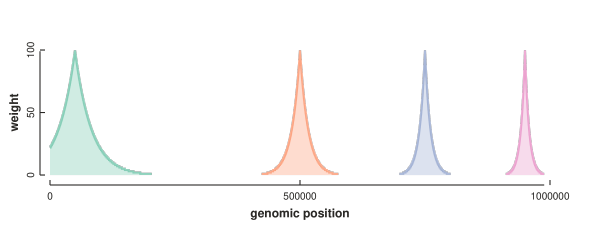

In [203]:
import toyplot.svg
import toyplot.pdf
toyplot.svg.render(canvas, "../manuscript/figures/Fig-weights.svg")
toyplot.pdf.render(canvas, "../manuscript/figures/Fig-weights.pdf")
canvas

In [232]:
#ipcoal.Model()